In [61]:
import torch 
import torchvision
from torch import nn
import numpy as np
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image,ImageOps
from torchvision import transforms
import glob
import os
import time
import PIL

In [62]:
cat_paths =[]
dog_paths = []
path = "C:\\Users\\user\\Desktop\\catsdogs\\PetImages"
for url in glob.glob(path+"\\Cat\\*.jpg"):
  cat_paths.append(url)


cat_paths = cat_paths[0:5000]
print(len(cat_paths))

5000


In [63]:
path = "C:\\Users\\user\\Desktop\\catsdogs\\PetImages"
for url in glob.glob(path+"\\Dog\\*.jpg"):
  dog_paths.append(url)
dog_paths = dog_paths[:5000]

In [64]:
print(len(dog_paths))
print(dog_paths[0].split("\\")[-2]) ## reaching labels

5000
Dog


In [65]:
img_paths = cat_paths + dog_paths
np.random.shuffle(img_paths)

In [66]:
len(img_paths)

10000

In [67]:
class MyDataset(Dataset):
    def __init__(self,path,transform=None):
        
        
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self,idx):
        img,label = Image.open(self.path[idx]).convert("RGB"),self.path[idx].split("\\")[-2]
    
        if self.transform is not None:
            img = self.transform(img)
        if label =="Dog":
            label = 1
        else:
            label = 0
        sample = (img,label)
        return sample

In [68]:
class_dict = {0:"cat",1:"dog"}

In [69]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
)

In [70]:
train_dataset = MyDataset(img_paths[:7500],train_transform)
test_dataset = MyDataset(img_paths[7500:],train_transform)

In [71]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,drop_last=True)

In [72]:
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True,drop_last=True)

In [73]:
batch_idx,(img,label) = next(enumerate(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32])
Label is  dog


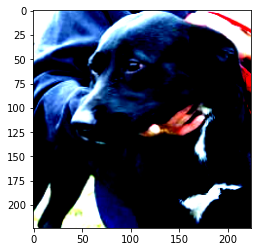

In [74]:
plt.imshow((torch.squeeze(img[4],dim=0)).permute(1,2,0))
print(label.shape)
print("Label is ", class_dict[label[4].item()])  
## images are transformed  to tensor and normalized we are ready to go



In [75]:
len(train_loader)

234

In [76]:
resnet = torchvision.models.resnet18(pretrained=True)

In [77]:
for param in resnet.parameters():
    param.requires_grad = False

In [78]:
in_f = resnet.fc.in_features
in_f

512

In [79]:
resnet.fc = nn.Sequential(
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Linear(128,2),
        nn.LogSoftmax()
)

In [80]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [81]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [82]:
# Define our loss function
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr = 0.005)

In [83]:
from tqdm import tqdm
epochs = 10
steps = 0
print_every = 32
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in tqdm(train_loader,desc=f"Training model  epoch {e}/{epochs}"):
        steps += 1

        optimizer.zero_grad()
    
        images = images
        labels = torch.tensor(labels)

        log_ps = resnet(images)
     
        loss = criterion(log_ps, labels)
        
        #backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                resnet.eval()
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    log_ps = resnet(images)
                    test_loss += criterion(log_ps, labels)

                    ps = log_ps
            
                    # Get our top predictions
                    pred = torch.max(log_ps.data,1)[1]
                    
                    equals = (pred==labels)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            resnet.train()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))
          

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Training model  epoch 0/10:   0%|                                                              | 0/234 [00:00<?, ?it/s]<ipython-input-83-c8cdc71ab0bd>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
Training model  epoch 0/10:  14%|██████▉                                            | 32/234 [02:54<2:07:53, 37.99s/it]

Epoch: 1/10..  Training Loss: 0.057..  Test Loss: 0.158..  Test Accuracy: 0.933


Training model  epoch 0/10:  27%|█████████████▉                                     | 64/234 [05:29<1:32:36, 32.69s/it]

Epoch: 1/10..  Training Loss: 0.075..  Test Loss: 0.076..  Test Accuracy: 0.969


Training model  epoch 0/10:  41%|████████████████████▉                              | 96/234 [08:00<1:15:21, 32.76s/it]

Epoch: 1/10..  Training Loss: 0.090..  Test Loss: 0.233..  Test Accuracy: 0.911


Training model  epoch 0/10:  55%|███████████████████████████▎                      | 128/234 [10:36<1:00:05, 34.01s/it]

Epoch: 1/10..  Training Loss: 0.118..  Test Loss: 0.082..  Test Accuracy: 0.966


Training model  epoch 0/10:  62%|████████████████████████████████▏                   | 145/234 [11:03<06:47,  4.58s/it]


KeyboardInterrupt: 

In [92]:
accuracy = 0 
with torch.no_grad():
                resnet.eval()
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    log_ps = resnet(images)
                    test_loss += criterion(log_ps, labels)

                    ps = log_ps
            
                    # Get our top predictions
                    pred = torch.max(log_ps.data,1)[1]
                    
                    equals = (pred==labels)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

In [96]:
print("Accuracy in test data ",100*(accuracy.item()/len(test_loader)))

Accuracy in test data  93.6298076923077
